In [1]:
!pip3 install transformers
!pip3 install scikit-multilearn
!pip3 install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt-get install -y --no-install-recommends libcudnn8
!apt-mark hold libcudnn8

!nvcc --version
!echo "cudnn version:"
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
E: Held packages were changed and -y was used without --allow-change-held-packages.
libcudnn8 was already set on hold.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cudnn version:
cat: /usr/local/cuda/include/cudnn_version.h: No such file or directory


In [3]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'



In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset
df = pd.read_csv("./data_balanced.csv")
df = df.drop(columns=['None', 'powerlabel'])
df.dropna(inplace=True)

# Convert labels to tensor
labels = df.iloc[:, 1:].values

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('publichealthsurveillance/PHS-BERT')

# Tokenize input sentences and create attention masks
input_ids = []
attention_masks = []

for sentence in df['Content']:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=387, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert input_ids and attention_masks to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Prepare data for train-test split
X = np.hstack([input_ids.numpy(), attention_masks.numpy()])
y = labels

# Split the data into training and testing sets
train_X, test_X, train_y, test_y, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = train_X[:, :387], train_X[:, 387:]
test_input_ids, test_attention_masks = test_X[:, :387], test_X[:, 387:]
train_labels, test_labels = train_y, test_y

# Define the path to save the model
model_path = "./trained_model"

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)

# Check if a saved model exists and load it, if it does
# Check if a saved model exists and load it, if it does
if os.path.exists(model_path):
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
else:
    # Initialize the model
    model = TFAutoModelForSequenceClassification.from_pretrained('publichealthsurveillance/PHS-BERT', num_labels=labels.shape[1], from_pt=True)

    # Compile the model for training
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(
        [train_input_ids, train_attention_masks],
        train_labels,
        epochs=10,
        batch_size=16,
        validation_data=(
            [test_input_ids, test_attention_masks],
            test_labels
        ),
        callbacks=[early_stopping, model_checkpoint]
    )


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1993/1993 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9274

1993/1993 [==============================] - 1224s 564ms/step - loss: 0.1928 - accuracy: 0.9274 - val_loss: 0.0967 - val_accuracy: 0.9672
Epoch 2/10
1993/1993 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9761

1993/1993 [==============================] - 1089s 546ms/step - loss: 0.0757 - accuracy: 0.9761 - val_loss: 0.0848 - val_accuracy: 0.9738
Epoch 3/10
1993/1993 [==============================] - 1002s 503ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.0863 - val_accuracy: 0.9756
Epoch 4/10
1993/1993 [==============================] - 1001s 503ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.1040 - val_accuracy: 0.9725


In [7]:
# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits  # Access the logits from the output object
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels


250/250 [==============================] - 82s 304ms/step


In [ ]:
# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("Classification report:")
print(report_df)


In [9]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, jaccard_score

# Micro-averaged precision, recall, and F1 score
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-averaged Precision:", micro_precision)
print("Micro-averaged Recall:", micro_recall)
print("Micro-averaged F1 score:", micro_f1)

# Macro-averaged precision, recall, and F1 score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)

# Hamming Loss
hamming = hamming_loss(true_labels, predicted_labels)
print("Hamming Loss:", hamming)

# Jaccard Score
jaccard = jaccard_score(true_labels, predicted_labels, average='samples')
print("Jaccard Score:", jaccard)


Micro-averaged Precision: 0.9584446036605224
Micro-averaged Recall: 0.9426045736980334
Micro-averaged F1 score: 0.9504585970804805
Macro-averaged Precision: 0.9642182150306408
Macro-averaged Recall: 0.9492236986793109
Macro-averaged F1 score: 0.9563739587324179
Hamming Loss: 0.02749941738522489
Jaccard Score: 0.556552474170745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


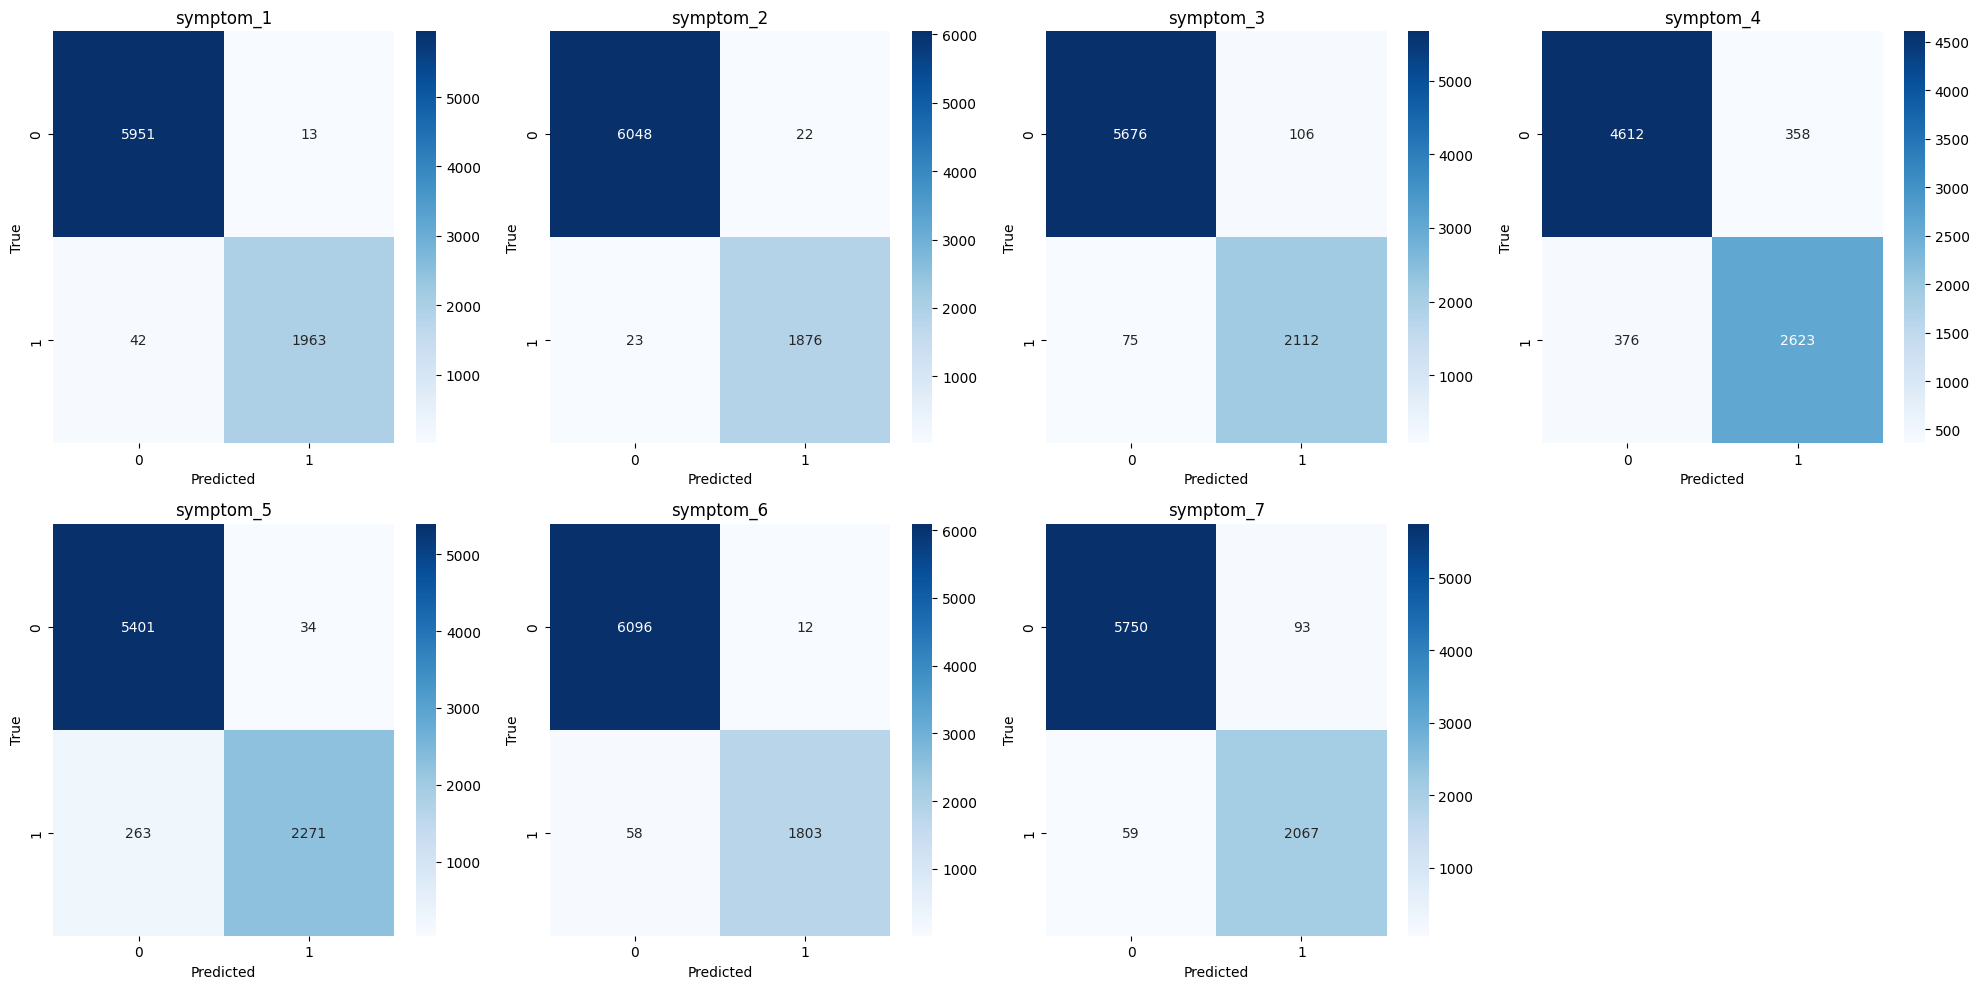

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt


# Calculate the confusion matrix
# Since this is a multi-label classification problem, we'll use multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
# label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.delaxes(axes[1, 3])  # remove the last subplot (as we have only 7 labels)

for i, (label_name, ax) in enumerate(zip(label_names, axes.flat)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{label_name}')

plt.tight_layout()
plt.show()

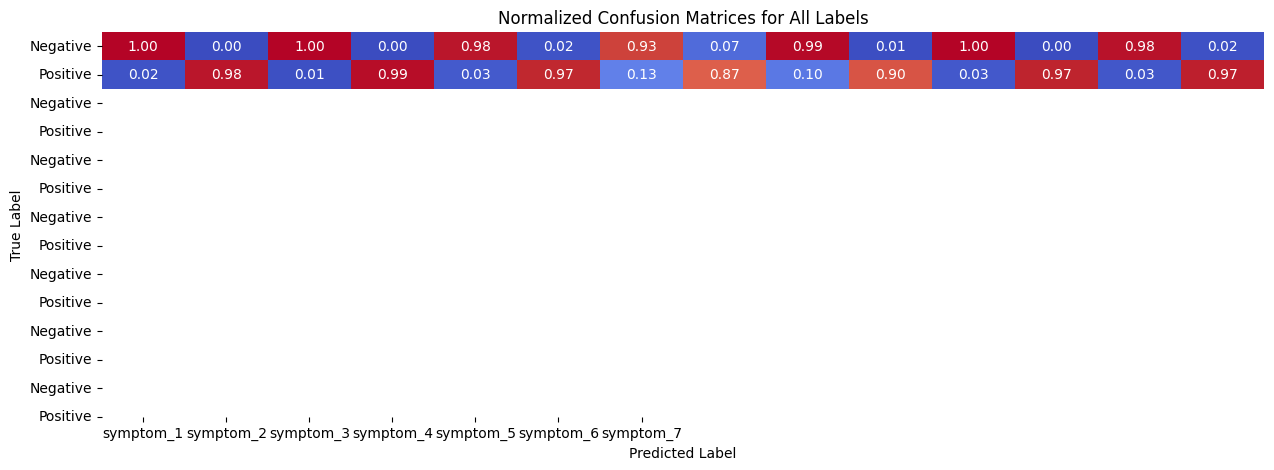

In [11]:
# Create an empty list to store the normalized confusion matrices for each label
confusion_matrices = []

# Calculate the confusion matrices for each label and normalize them
for i in range(7):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)

# Combine the normalized confusion matrices into a single array
combined_cm = np.concatenate(confusion_matrices, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(combined_cm, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, xticklabels=label_names, yticklabels=["Negative", "Positive"] * 7)

plt.title("Normalized Confusion Matrices for All Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Extract F1 scores for each label
f1_scores = {label: report[label]['f1-score'] for label in label_names}

# Create a heatmap of F1 scores
f1_scores_matrix = np.array(list(f1_scores.values())).reshape(1, -1)
plt.figure(figsize=(10, 1))
sns.heatmap(f1_scores_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=['F1 Score'], cmap='coolwarm', vmin=0, vmax=1)
plt.title('F1 Scores Heatmap')
plt.show()


NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def all_correct_percentage(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    percentage = np.sum(correct) / len(correct)
    return percentage

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the percentage
fig, ax = plt.subplots(figsize=(6, 1))
ax.barh(['All Correct'], [all_correct_pct], color='blue')
ax.set_xlim(0, 1)
ax.set_xlabel('Percentage')
ax.set_title('Percentage of Instances with All Labels Predicted Correctly')
plt.show()

def exact_match_ratio(true_labels, predicted_labels):
    assert true_labels.shape == predicted_labels.shape
    return np.all(true_labels == predicted_labels, axis=1).mean()

exact_match = exact_match_ratio(true_labels, predicted_labels)
print(f"Exact Match Ratio: {exact_match:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1 score from the classification report
precision = [report[label]['precision'] for label in label_names]
recall = [report[label]['recall'] for label in label_names]
f1_score = [report[label]['f1-score'] for label in label_names]

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the metrics together
fig, ax = plt.subplots(figsize=(10, 5))
labels = np.arange(len(label_names))
width = 0.2

rects1 = ax.bar(labels - 1.5 * width, precision, width, label='Precision')
rects2 = ax.bar(labels - 0.5 * width, recall, width, label='Recall')
rects3 = ax.bar(labels + 0.5 * width, f1_score, width, label='F1 Score')
rects4 = ax.bar(labels + 1.5 * width, [all_correct_pct] * len(labels), width, label='All Correct %')

ax.set_xlabel('Labels')
ax.set_xticks(labels)
ax.set_xticklabels(label_names)
ax.set_ylabel('Score')
ax.set_title('Metrics by Label')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()


In [ ]:
import seaborn as sns
from collections import Counter

def label_combination_counts(labels):
    label_counts = Counter()
    for row in labels:
        label_counts[tuple(row)] += 1
    return label_counts

true_label_counts = label_combination_counts(true_labels)
predicted_label_counts = label_combination_counts(predicted_labels)

label_combinations = sorted(set(list(true_label_counts.keys()) + list(predicted_label_counts.keys())))
true_label_freq = [true_label_counts[combination] for combination in label_combinations]
predicted_label_freq = [predicted_label_counts[combination] for combination in label_combinations]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
fig.suptitle('Heatmap of Label Combinations')

sns.heatmap([true_label_freq], xticklabels=label_combinations, yticklabels=["True"], annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
sns.heatmap([predicted_label_freq], xticklabels=label_combinations, yticklabels=["Predicted"], annot=True, fmt="d", cmap="YlGnBu", ax=ax2)

plt.show()


In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC for each label

n_classes = train_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Rest of the code remains the same


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Label {i + 1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate Precision-Recall curve and AUC-PR for each label
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], logits[:, i])
    average_precision[i] = average_precision_score(true_labels[:, i], logits[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Label {i + 1} (AUC-PR = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc="upper right")
plt.show()

In [ ]:
from transformers import TFBertModel

# Get the attention weights from BERT
def get_attention_weights(input_ids, attention_masks):
    bert = TFBertModel.from_pretrained('bert-base-uncased', output_attentions=True)
    outputs = bert(input_ids, attention_mask=attention_masks)
    attentions = outputs.attentions
    return attentions

# Analyze the attention weights for a specific sample
sample_index = 0  # Change this to analyze different samples
input_id_sample = test_input_ids[sample_index].reshape(1, -1)
attention_mask_sample = test_attention_masks[sample_index].reshape(1, -1)

# Convert tensors to the appropriate format
input_id_sample = tf.convert_to_tensor(input_id_sample)
attention_mask_sample = tf.convert_to_tensor(attention_mask_sample)

attentions = get_attention_weights(input_id_sample, attention_mask_sample)

# Get the words from the input_ids
tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0])

# Print the attention weights for the sample
for i, attention in enumerate(attentions):
    print(f"Layer {i + 1}")
    print(tokens)
    print(attention[0][0].numpy())
    print("\n")


In [ ]:
'''qualitative example'''
# Define indices of examples to examine
example_indices = [0, 1, 2, 3, 4, 5, 6]

# Convert the predicted probabilities to binary labels
test_predictions = model.predict([test_input_ids, test_attention_masks])
test_binary_predictions = (np.array(test_predictions.logits, dtype=float) >= 0.5).astype(int)

# Define label names
label_names = ['happiness', 'love', 'enthusiasm', 'fun', 'surprise', 'neutral', 'sadness']

# Choose some examples to examine in more detail
for i in example_indices:
    # Get the input text and true label for the example
    input_text = df['Content'].iloc[test_index[i]]
    true_label = test_labels[i]

    # Get the predicted label for the example
    predicted_label = test_binary_predictions[i]

    # Map the predicted label indices to their names
    predicted_label_names = [label_names[j] for j, label in enumerate(predicted_label) if label == 1]

    # Print the input text, true label, and predicted label
    print("Input text:", input_text)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)

   


In [ ]:
# Error analysis
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels



In [ ]:
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
    if not np.array_equal(pred, true):
        errors.append(i)

print(f"Total errors: {len(errors)}")



# Inspect a specific error
for i in range(1000):
  error_index = errors[i]  # Change this to analyze different errors
  error_df_index = test_index[error_index]  # Get the index in the original dataframe
  print(f"Error {error_index}")
  print("Content: ", df.iloc[error_df_index]['Content'])  # Print the content of the misclassified sample
  print("True labels: ", true_labels[error_index])
  print("Predicted labels: ", predicted_labels[error_index])
  error_content = df.iloc[error_df_index]['Content']
  print(f"Content: {error_content}")
